In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-06-03 15:00:24.381047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 15:00:26.107477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-03 15:00:29.141545: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

## Test Basic UMAP

In [7]:
import umap
from sklearn.datasets import load_digits

2023-04-18 16:40:26.615891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 16:40:27.477727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-18 16:40:27.477810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-18 16:40:27.477819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
digits = load_digits()

embedding = umap.UMAP().fit_transform(digits.data)

2023-04-18 15:58:30.961507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:58:31.787212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-18 15:58:31.787290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-18 15:58:31.787299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<Axes: >

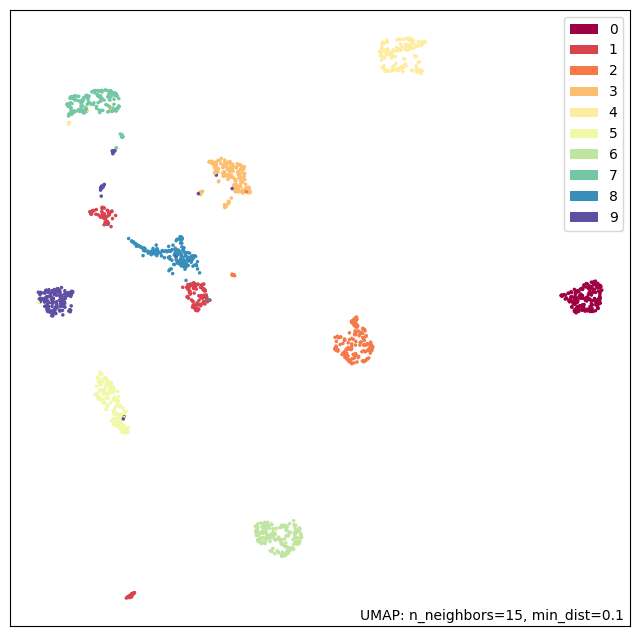

In [4]:
import umap
import umap.plot
from sklearn.datasets import load_digits

digits = load_digits()

mapper = umap.UMAP().fit(digits.data)
umap.plot.points(mapper, labels=digits.target)

In [3]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

## Test Umap with Spectograms

### Load the dfs

In [3]:
# Utils
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm
from datetime import datetime
import json
from IPython.display import display, Audio
from pathlib2 import Path

# data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

# wrapper lib
from avgn.utils.paths import DATA_DIR, ensure_dir

DATA_DIR = Path('./data')
DSLOC = DATA_DIR / 'raw' / 'fruitbat'

PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis


In [4]:
annotations =  pd.read_csv(DSLOC/'Annotations.csv')

annotations = annotations.astype({
    'FileID' : int,
    'Emitter' : int,
    'Addressee' : int,
    'Context' :int,
    'Emitter pre-vocalization action' : int,
    'Addressee pre-vocalization action': int,
    'Emitter post-vocalization action' : int,
    'Addressee post-vocalization action' : int,
    'Start sample': float,
    'End sample' : float
})

len(annotations)

91080

In [5]:
""" fruit bat db is malformed. 
Recreate the db with proper columns.
"""

with open(DSLOC/'FileInfo.csv', 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
file_info = pd.read_csv(DSLOC/'FileInfo.csv', header=None, delimiter=",", names=column_names)
file_info, file_info.columns = file_info[1:] , file_info.iloc[0]

# recreate the header
samples_boundaries = np.arange(1, 1 + file_info.shape[1] - 6)
voice_starts = samples_boundaries[::2]
voice_ends = samples_boundaries[1::2]
col_samples_boundaries = { val : float for pair in zip(['voice_start_sample_{}'.format(i + 1)for i in range(len(voice_starts))  ], 
        ['voice_end_sample_{}'.format(i + 1) for i in range(len(voice_ends))  ]) for val in pair }

col_names = ['FileID','Treatment ID','File name','File folder','Recording channel','Recording time'] + \
    [ val for pair in zip(['voice_start_sample_{}'.format(i + 1)for i in range(len(voice_starts))  ], 
        ['voice_end_sample_{}'.format(i + 1) for i in range(len(voice_ends))  ]) for val in pair]

columns_types = {
    'FileID' : int,
    'Treatment ID' : int,
    'File name' : str,
    'File folder' : str,
    'Recording channel' : int,
    'Recording time' : 'datetime64[ms]',
} | col_samples_boundaries
 

# set the new header
file_info.columns = columns_types.keys()


#ensure datatypes are meaningful
file_info = file_info.astype(columns_types)

# set index
file_info.set_index('FileID', inplace=True)

# shape
file_info.shape

/tmp/ipykernel_1182070/781315627.py:13: DtypeWarning: Columns (0,1,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  file_info = pd.read_csv(DSLOC/'FileInfo.csv', header=None, delimiter=",", names=column_names)


(293238, 331)

In [6]:
# Wav files
wavfiles = list(DSLOC.glob('zip_contents/*/*.WAV'))
len(wavfiles), wavfiles[0]

wf_df = pd.DataFrame(
    [[wf, wf.name, wf.parent.stem] for wf in tqdm(wavfiles)],
    columns=["wav_loc", "id", "folder"],
)
wf_df = wf_df.set_index('id')
len(wf_df)

  0%|          | 0/293238 [00:00<?, ?it/s]

293238

### Vocalizations for one Emitter

In [225]:
import seaborn as sns
import colorcet

import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler

In [226]:
context_dict = {
    0:'Unknown',
    1:'Separation',
    2:'Biting',
    3:'Feeding',
    4:'Fighting',
    5:'Grooming',
    6:'Isolation',
    7:'Kissing',
    8:'Landing',
    9:'Mating protest',
    10:'Threat-like',
    11:'General',
    12:'Sleeping',
}

In [227]:
q = annotations.query('Emitter in [215] and Addressee not in [0, 11, 12] and Context not in [0,11,12]')

sample_fileIDs = file_info.query('FileID in [{}]'.format(','.join(str(x) for x in q['FileID'])))

In [228]:
import datetime

# get a datetime that is equal to epoch
def time2Float(x):
    epoch = datetime.datetime(1970, 1, 1)
    return (x - epoch).total_seconds()

In [229]:
#emitter = 215
#sample_annotations = annotations[annotations.Emitter == emitter]

sample_annotations = q.copy()
sample_annotations.set_index('FileID', inplace = True)

# add Duration column
sr = 250000
sample_annotations.loc[:,'Duration'] = 1/sr * (sample_annotations['End sample']  - sample_annotations['Start sample'])

# add DateTime
sample_annotations['DateTime'] = sample_fileIDs['Recording time']
sample_annotations['ContextHour'] = sample_annotations['DateTime'].apply(lambda x:x.hour)
sample_annotations['DateTime'] = sample_annotations['DateTime'].apply(time2Float)

# dictionary
sample_annotations['ContextLabel']  = sample_annotations['Context'].apply( lambda x  : context_dict[x])
sample_annotations

,Emitter,Addressee,Context,Emitter pre-vocalization action,Addressee pre-vocalization action,Emitter post-vocalization action,Addressee post-vocalization action,Start sample,End sample,Duration,DateTime,ContextHour,ContextLabel
FileID,,,,,,,,,,,,,
61822,215,217,6,0,0,0,0,1.0,320336.0,1.281340,1.349370e+09,16,Isolation
61879,215,217,6,0,0,0,0,1.0,328528.0,1.314108,1.349371e+09,17,Isolation
61882,215,217,6,0,0,0,0,1.0,320336.0,1.281340,1.349372e+09,17,Isolation
61894,215,217,6,0,0,0,0,1.0,557904.0,2.231612,1.349372e+09,17,Isolation
61900,215,217,6,0,0,0,0,1.0,320336.0,1.281340,1.349372e+09,17,Isolation
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293146,215,221,9,2,2,3,3,1.0,4514640.0,18.058556,1.392788e+09,5,Mating protest
293155,215,221,9,2,2,3,3,1.0,2065232.0,8.260924,1.392789e+09,5,Mating protest
293179,215,221,9,2,2,3,3,1.0,426832.0,1.707324,1.392789e+09,5,Mating protest


<Axes: xlabel='Context', ylabel='ContextHour'>

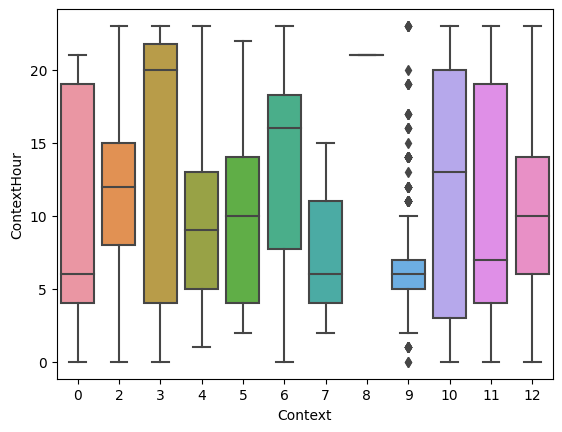

In [168]:
# create a box plot
sns.boxplot(x='Context', y='ContextHour', data=sample_annotations)

In [169]:
# perform the Kruskal-Wallis test

from scipy.stats import kruskal

stat, pval = kruskal(*hours_by_context[-4])
print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {pval}")

Kruskal-Wallis test statistic: 628.0
p-value: 0.4924953297179439


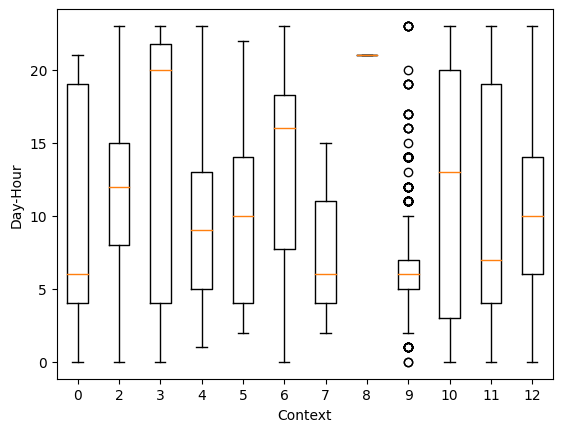

In [170]:
# calculate the mean datetime value for each category
means = sample_annotations.groupby('Context')['ContextHour'].mean()

# plot the means using a box plot
# create a list of datetime values for each category
hours_by_context = [sample_annotations[sample_annotations['Context'] == cat]['ContextHour'].values for cat in means.index]

# plot the values using a box plot
plt.boxplot(hours_by_context, labels=means.index)
plt.xlabel('Context')
plt.ylabel('Day-Hour')
plt.show()

In [171]:
# Let's test how it clusterize with current info

In [230]:
emitter_data = sample_annotations[
    [
     'ContextHour', 'Duration', 'Context'
    ]
].values

scaled_emitter_data = StandardScaler().fit_transform(emitter_data)

In [231]:
# test PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

PCA_on_scaled_emitter_data = pca.fit_transform(scaled_emitter_data)

<Axes: >

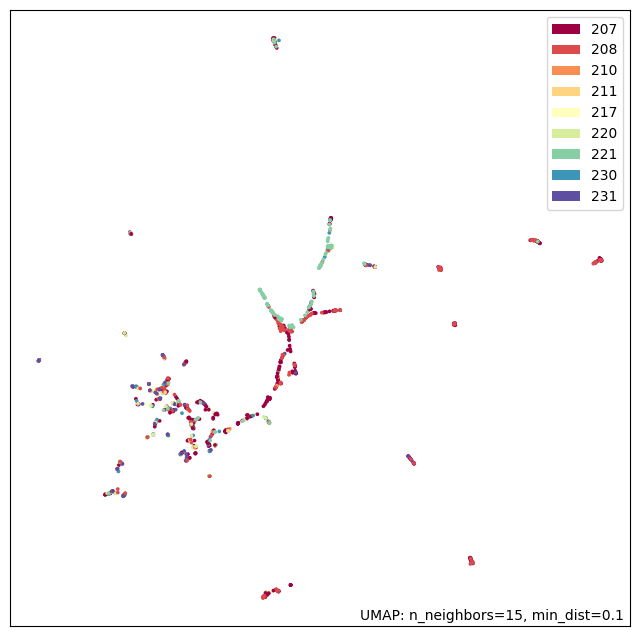

In [232]:
umap.plot.points(reducer.fit(PCA_on_scaled_emitter_data), labels=sample_annotations['Addressee'])

<Axes: >

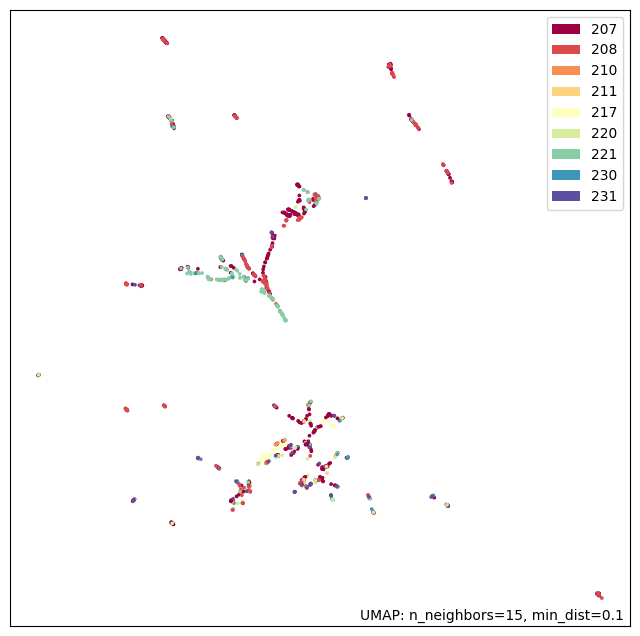

In [234]:
umap.plot.points(reducer.fit(scaled_emitter_data), labels=sample_annotations['Addressee'])

In [182]:
emitter_data

array([[ 16, 217],
       [ 17, 217],
       [ 17, 217],
       ...,
       [  5, 221],
       [  5, 221],
       [  5, 221]])

In [173]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_emitter_data)
embedding.shape

(6043, 2)

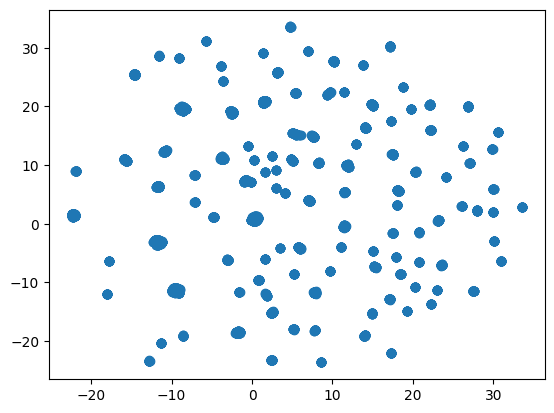

In [176]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1]
)

In [174]:
sample_annotations.Context.value_counts()

12    4134
9      629
11     627
2      292
3       90
6       64
4       50
7       48
10      48
5       47
0       13
8        1
Name: Context, dtype: int64

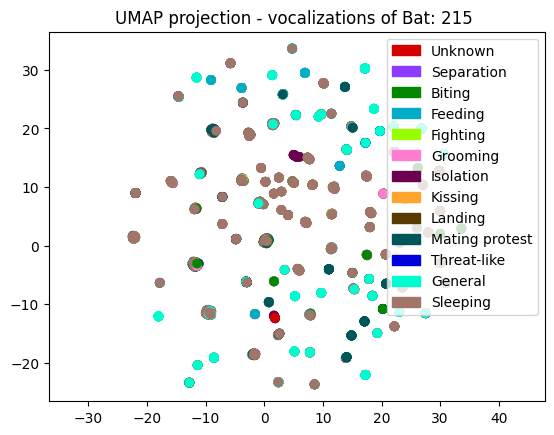

In [175]:
palette = sns.color_palette(colorcet.glasbey, n_colors=13)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[palette[x] for x in sample_annotations.Context]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP projection - vocalizations of Bat: {emitter} ', fontsize=12);
plt.legend(handles = [mpatches.Patch(color= palette[x], label= context_dict[x]) for x in context_dict])
plt.show()

In [111]:
# Let's test how it clusterize with info on length of vocalization

In [206]:
def compute_plot_Umap(sample_annotations, selected_columns):
    
    # compute embedding
    emitter_data = sample_annotations[
        list(selected_columns)
    ].values

    scaled_emitter_data = StandardScaler().fit_transform(list(emitter_data))
    embedding = reducer.fit_transform(scaled_emitter_data)

    # plot
    palette = sns.color_palette(colorcet.glasbey, n_colors=13)

    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[palette[x] for x in sample_annotations.Context]
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection - vocalizations of Bat: {emitter} ', fontsize=12);
    plt.legend(handles = [mpatches.Patch(color= palette[x], label= context_dict[x]) for x in context_dict])
    plt.show()

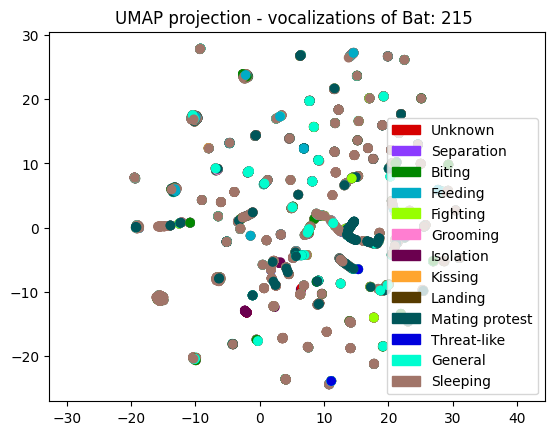

In [207]:
compute_plot_Umap(sample_annotations, ['Duration', 'Addressee'])

In [139]:
### Let's see with features extracted from wav files

In [146]:
#### Experiment 
# Let's add information about daytime, splitting the day in 24h
# Let's add array of duration of vocalizations and 'silent' intervals in between

In [166]:
sample_emitter_df = file_info.loc[annotations[annotations.Emitter == emitter].FileID].fillna(0)


sample_emitter_df.head(2)

,Treatment ID,File name,File folder,Recording channel,Recording time,voice_start_sample_1,voice_end_sample_1,voice_start_sample_2,voice_end_sample_2,voice_start_sample_3,...,voice_start_sample_159,voice_end_sample_159,voice_start_sample_160,voice_end_sample_160,voice_start_sample_161,voice_end_sample_161,voice_start_sample_162,voice_end_sample_162,voice_start_sample_163,voice_end_sample_163
FileID,,,,,,,,,,,,,,,,,,,,,
61822,13,121004165931143478.WAV,files201,9,2012-10-04 16:59:31,35795.0,71747.0,210795.0,242041.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61879,13,121004172433181482.WAV,files201,9,2012-10-04 17:24:33,45141.0,74887.0,166141.0,195075.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
end_times = sample_emitter_df.loc[:, sample_emitter_df.columns.str.startswith('voice_end_sample_')].values 
start_times = sample_emitter_df.loc[:, sample_emitter_df.columns.str.startswith('voice_start_sample_')].values


sample_emitter_df['Durations'] = pd.Series(list( end_times - start_times )).to_numpy()

In [263]:
sample_emitter_df['Durations'] = sample_emitter_df['Durations'].apply(lambda x : (x - min(x)) / (max(x) - min(x)))

In [261]:
sample_emitter_df['Durations'].apply(lambda x : (x - np.mean(x)) / np.std(x))

FileID
61822     [9.584556902618338, 8.315416446751483, -0.1111...
61879     [9.096994679438088, 8.845624650182534, -0.1114...
61882     [12.727922061357853, -0.07856742013183861, -0....
61894     [7.409982763001502, 7.409982763001502, 7.08418...
61900     [12.72792206135786, -0.07856742013183864, -0.0...
                                ...                        
293146    [0.5878458621840972, 1.5710362996854623, 0.956...
293155    [1.0406929884224367, 1.219410848690782, 1.4504...
293179    [4.920394740617939, 6.004978437779724, 7.36506...
293182    [0.7559439286033104, 0.9124152037726178, 0.716...
293184    [3.8643390684311365, 4.900013211953812, 2.1830...
Name: Durations, Length: 6150, dtype: object

In [274]:
sample_emitter_df['Context'] = annotations[annotations.Emitter == emitter].set_index('FileID').Context
sample_emitter_df['Addressee'] = annotations[annotations.Emitter == emitter].set_index('FileID').Addressee

In [216]:
from umap import UMAP

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)


UMAP(low_memory=False, random_state=42)

In [223]:
data = StandardScaler().fit_transform(list(sample_emitter_df['Durations']))

In [259]:


from sklearn.preprocessing import normalize

data = normalize(list(sample_emitter_df['Durations']), axis=1, norm='l1')
data

array([[0.53501592, 0.46498408, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50691888, 0.49308112, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.19838097, 0.24075701, 0.29389732, ..., 0.        , 0.        ,
        0.        ],
       [0.01587895, 0.01789584, 0.01537473, ..., 0.        , 0.        ,
        0.        ],
       [0.12468139, 0.15645279, 0.07310453, ..., 0.        , 0.        ,
        0.        ]])

In [322]:
data = list(sample_emitter_df['Durations'])
len(data[0])

163

In [ ]:
data = sample_emitter_df[['Addressee','Durations']].values

In [320]:
StandardScaler().fit_transform(sample_emitter_df[['Addressee']].values)

array([[0.22059577],
       [0.22059577],
       [0.22059577],
       ...,
       [0.3572254 ],
       [0.3572254 ],
       [0.3572254 ]])

In [308]:
data = []
for i, a in enumerate(sample_emitter_df['Durations'].tolist()):
    data.append( np.insert(a, 0, sample_emitter_df.iloc[i]['Addressee'], axis=0) )

In [296]:
pd.DataFrame(sample_emitter_df['Durations'].values)

,0
0,"[1.0, 0.869103248776146, 0.0, 0.0, 0.0, 0.0, 0..."
1,"[1.0, 0.972702212062126, 0.0, 0.0, 0.0, 0.0, 0..."
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[1.0, 1.0, 0.9568295631151787, 0.0, 0.0, 0.0, ..."
4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
6145,"[0.32171743655749946, 0.5957318332777168, 0.42..."
6146,"[0.18924543826533083, 0.2137037574818902, 0.24..."
6147,"[0.6750009343349404, 0.8191875023358374, 1.0, ..."
6148,"[0.2921444209432632, 0.3292515492226057, 0.282..."


In [323]:
reducer = umap.UMAP(random_state=42)
reducer.fit(data)

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [324]:
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(6150, 2)

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=sample_emitter_df['Context'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(14)-0.5).set_ticks(np.arange(13))
plt.title(f'UMAP projection of Bat {emitter}', fontsize=12);

In [252]:
annotations[annotations.Emitter == emitter].Addressee.value_counts()

207    2708
220    1526
230     563
208     495
231     290
221     155
211     125
210     113
0       107
217      68
Name: Addressee, dtype: int64

In [210]:
scaled_emitter_data = StandardScaler().fit_transform(list(sample_emitter_df['Durations']))

scaled_emitter_data

array([[ 1.53678761,  1.03388835, -0.67550254, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84243536,  0.88948038, -0.67550254, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61866731, -0.91774286, -0.67550254, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.46492946,  0.45132212,  1.08654078, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72394097,  0.19067574,  0.32850062, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46067787,  0.5007906 ,  0.02333528, ...,  0.        ,
         0.        ,  0.        ]])

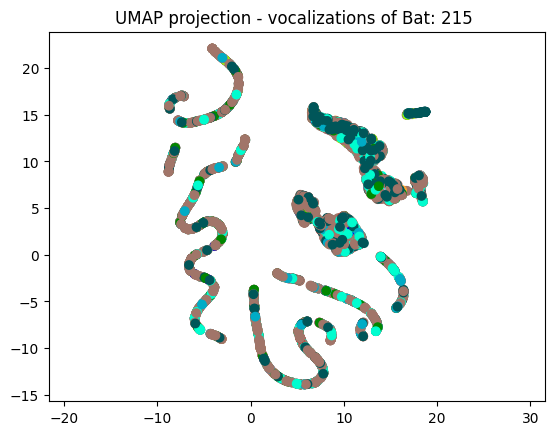

In [214]:
reducer = umap.UMAP(random_state=42)

scaled_emitter_data = StandardScaler().fit_transform(list(sample_emitter_df['Durations']))
embedding = reducer.fit(scaled_emitter_data)

# plot
palette = sns.color_palette(colorcet.glasbey, n_colors=13)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[palette[x] for x in sample_emitter_df.Context]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP projection - vocalizations of Bat: {emitter} ', fontsize=12);
#plt.legend(handles = [mpatches.Patch(color= palette[x], label= context_dict[x]) for x in context_dict])
plt.show()

In [208]:
compute_plot_Umap(sample_emitter_df, ['Durations'])

ValueError: setting an array element with a sequence.

# using parametric UMAP

In [16]:
from tensorflow.keras.datasets import mnist

In [17]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
X = train_images.reshape((60000, 28, 28, 1))
X.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

In [21]:
#dependencies for numba
#!pip install llvmlite>=0.34.0

In [22]:
#dependencies for knn estimators
#!pip install --upgrade pynndescent

In [20]:
from pynndescent import NNDescent
import numpy as np

In [23]:
# number of trees in random projection forest
n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(X.shape[0]))))
# distance metric
metric="euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 10

# get nearest neighbors
nnd = NNDescent(
    X.reshape((len(X), np.product(np.shape(X)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

Sun Mar  5 10:46:34 2023 Building RP forest with 17 trees
Sun Mar  5 10:47:26 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [24]:
# nearest neighbors and distances for each point in the dataset
np.shape(knn_indices), np.shape(knn_dists)

((60000, 10), (60000, 10))

In [25]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set

In [26]:
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [27]:
# build fuzzy_simplicial_set
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X = X,
    n_neighbors = n_neighbors,
    metric = metric,
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)

In [28]:
umap_graph

<60000x60000 sparse matrix of type '<class 'numpy.float32'>'
	with 803600 stored elements in Compressed Sparse Row format>

In [29]:
import tensorflow as tf

In [30]:
n_components = 2 # number of latent dimensions
dims = X.shape[1:]
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

2023-03-05 10:48:34.293999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-05 10:48:34.310726: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-05 10:48:34.363216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 512)               3211776   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 3,549,954
Trainable params: 3,549,954
Non-

In [31]:
from umap.parametric_umap import construct_edge_dataset

In [32]:
# n_epochs isused to compute epochs_per_sample, which, in non-parametric UMAP, 
# is the total number of epochs to optimize embeddings over. The computed value 
# epochs_per_sample, is the number of epochs  each edge is optimized over 
# (higher probability = more epochs).
n_epochs = 200 

batch_size = 1000 # iterate over batches of 1000 edges

In [35]:
# get tensorflow dataset of edges 
(
    edge_dataset,
    batch_size,
    n_edges,
    head,
    tail,
    edge_weight,
) = construct_edge_dataset(
    X,
    umap_graph,
    n_epochs,
    batch_size,
    parametric_embedding = True,
    parametric_reconstruction = False,
    global_correlation_loss_weight = 0
)

2023-03-05 10:56:58.814518: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 522757296 exceeds 10% of free system memory.
2023-03-05 10:57:14.163053: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 522757296 exceeds 10% of free system memory.


In [36]:
(sample_edge_to_x, sample_edge_from_x), _ =  next(iter(edge_dataset))
sample_edge_to_x.shape

2023-03-05 10:57:18.470106: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 522757296 exceeds 10% of free system memory.
2023-03-05 10:57:18.921718: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 522757296 exceeds 10% of free system memory.


TensorShape([1000, 28, 28, 1])

In [37]:
import matplotlib.pyplot as plt

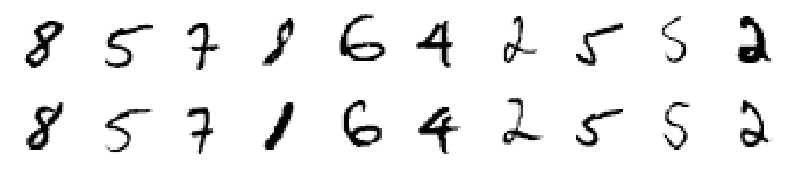

In [38]:
# plot sampled neighbors from graph
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
for i in range(10):
    axs[0,i].matshow(np.squeeze(sample_edge_to_x[i]), cmap=plt.cm.Greys)
    axs[1,i].matshow((np.squeeze(sample_edge_from_x[i])), cmap=plt.cm.Greys)
    axs[0,i].axis('off')
    axs[1,i].axis('off')

In [39]:
from umap.parametric_umap import umap_loss

In [40]:
from umap.umap_ import find_ab_params

In [41]:
min_dist = 0.1 # controls how tightly UMAP is allowed to pack points together (0 is more)

In [42]:
_a, _b = find_ab_params(1.0, min_dist)

In [43]:
# grab z for the edge
embedding_to = encoder.predict(sample_edge_to_x)
embedding_from = encoder.predict(sample_edge_from_x)

32/32 [==============================] - 1s 16ms/step


In [44]:
negative_sample_rate = 5 # how many negative samples to train on per edge. 

In [45]:
# get negative samples by randomly shuffling the batch
embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
embedding_neg_from = tf.gather(
    repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
)

In [46]:
# Euclidean distances between samples (and negative samples)
distance_embedding = tf.concat(
    [
        tf.norm(embedding_to - embedding_from, axis=1),
        tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
    ],
    axis=0,
)

In [47]:
def convert_distance_to_probability(distances, a=1.0, b=1.0):
    return 1.0 / (1.0 + a * distances ** (2 * b))

# convert probabilities to distances
probabilities_distance = convert_distance_to_probability(
    distance_embedding, _a, _b
)

In [48]:
# set true probabilities based on negative sampling
probabilities_graph = tf.concat(
    [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)], axis=0,
)

In [49]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    # cross entropy
    attraction_term = -probabilities_graph * tf.math.log(
        tf.clip_by_value(probabilities_distance, EPS, 1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

In [50]:
from umap.parametric_umap import umap_loss 

umap_loss_fn = umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weight,
    parametric_embedding = True
)

In [51]:
# define the inputs
to_x = tf.keras.layers.Input(shape=dims, name="to_x")
from_x = tf.keras.layers.Input(shape=dims, name="from_x")
inputs = [to_x, from_x]

# parametric embedding
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)

# concatenate to/from projections for loss computation
embedding_to_from = tf.concat([embedding_to, embedding_from], axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
    embedding_to_from
)
outputs = {'umap': embedding_to_from}

# create model
parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

In [52]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [53]:
parametric_model.compile(
    optimizer=optimizer, loss=umap_loss_fn
)

In [54]:
# Steps per epoch determines how many training steps we take, before keras 
#. starts a new epoch. To get more frequent reporting, you can set the number
#. of epochs higher and the number of steps per epoch lower. 
steps_per_epoch = int(
    n_edges / batch_size / 5
)

In [ ]:
# create embedding
history = parametric_model.fit(
    edge_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=100,
)

Epoch 1/20
12545/13068 [===========================>..] - ETA: 6:33 - loss: 0.1061

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
# Project data
z = encoder.predict(X)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)

# UMAP on preprocessed data

In [1]:
import automutualinformation
import pickle

import automutualinformation
import pickle

def load_seq_data( dataset_descriptor):
    # Load The Sequences!
    with open(f'symbolic_sequences_{dataset_descriptor}_All.pkl','rb') as f:
        symbolic_sequences = pickle.load(f)

    # Load The Graph!
    with open(f'graph_symbolic_sequences_{dataset_descriptor}_All.pkl','rb') as f:
        G = pickle.load(f)

    # Load The Sequences!
    with open(f"{dataset_descriptor}_All_mapped.pkl",'rb') as f:
        seq_mapped = pickle.load(f)
        seq_mapped.drop_duplicates(subset=["voc_segments_ix"], keep="first", inplace=True)
        seq_mapped.index = range(len(seq_mapped.index))
        seq_mapped.index.set_names('segmentID', inplace=True)
        
    return symbolic_sequences, G, seq_mapped
    
symbolic_sequences, G, seq_mapped = load_seq_data( 'offspring_relationships_372')

In [2]:
symbolic_sequences.head()

,File name,Seq_Syllables,Seq_Syllables_ix,Pos_Segment,Duration,Folder,FileID,Emitter,label_addressee,label_context
0,121003123656832262.WAV,"[71, 163]","[0, 1]","[0, 1]","[44695, 42302]",files201,59995,[213],"[111, 111]","[11, 11]"
1,121023050348116079.WAV,"[301, 26, 55, 325]","[2, 3, 4, 5]","[0, 1, 2, 3]","[16362, 35444, 73008, 27135]",files203,78249,[213],"[120, 120, 120, 120]","[11, 11, 11, 11]"
2,121027172341023513.WAV,[18],[6],[0],[20302],files203,81249,[213],[120],[3]
3,121028160637448106.WAV,"[73, 44]","[7, 8]","[0, 1]","[21459, 64763]",files203,81950,[213],"[120, 120]","[11, 11]"
4,121031191209491750.WAV,"[316, 43, 25, 236]","[9, 10, 11, 12]","[0, 1, 2, 3]","[7757, 30490, 49114, 17939]",files204,84533,[213],"[111, 111, 111, 111]","[11, 11, 11, 11]"


In [3]:
seq_mapped.head()

,syllableID,commonSourceID,voc_segments,voc_segments_ix,voc_segments_duration,emitter,mfccs,mel_filtered,specs,bandwidths,...,temporal_stats,label_context,label_addressee,FileID,Folder,File name,Pos_segment,Start_seg,End_seg,Emitter
segmentID,,,,,,,,,,,,,,,,,,,,,
0,71,0,"[-1.1423192e-05, 5.418589e-06, 1.7332432e-06, ...","(59995.0, files201, 121003123656832262.WAV, 0,...",44695,213,"[[-713.8833, -713.1924, -713.4439, -703.8752, ...","[[4.488716e-08, 2.24326e-08, 8.862967e-10, 1.1...","[[6.8280974e-06, 3.4874517e-06, 1.1220982e-07,...","[[21809.47963411824, 22091.035088101828, 36852...",...,0.000322,11,111,59995.0,files201,121003123656832262.WAV,0,53896,98591,213
1,163,0,"[-5.017855e-07, 2.4385608e-06, -4.323834e-06, ...","(59995.0, files201, 121003123656832262.WAV, 1,...",42302,213,"[[-797.9512, -787.25134, -769.4923, -738.72815...","[[4.010896e-08, 2.0535618e-08, 3.8743615e-08, ...","[[6.38061e-06, 2.5093527e-06, 5.657315e-06, 6....","[[46618.564945776445, 49231.11944259624, 35669...",...,0.000347,11,111,59995.0,files201,121003123656832262.WAV,1,98613,140915,213
2,301,0,"[-7.723826e-06, 4.0895793e-06, -1.1434331e-06,...","(78249.0, files203, 121023050348116079.WAV, 0,...",16362,213,"[[-787.4678, -780.23456, -776.3801, -774.8462,...","[[8.952682e-08, 4.718989e-08, 1.0944717e-08, 9...","[[1.3051949e-05, 5.6492345e-06, 1.6980036e-06,...","[[32611.848579937625, 37021.766843059864, 4048...",...,0.000121,11,120,78249.0,files203,121023050348116079.WAV,0,47747,64109,213
3,26,0,"[4.7641697e-06, -3.863653e-06, 2.6486614e-06, ...","(78249.0, files203, 121023050348116079.WAV, 1,...",35444,213,"[[-715.831, -715.2192, -715.3533, -710.0295, -...","[[6.4451534e-08, 5.805203e-08, 2.728951e-08, 6...","[[1.1977725e-05, 1.3276762e-05, 5.6109566e-06,...","[[23172.69510239572, 19155.768426082654, 46196...",...,0.000228,11,120,78249.0,files203,121023050348116079.WAV,1,122211,157655,213
4,55,0,"[-1.6108176e-07, -6.720924e-08, 3.5554928e-07,...","(78249.0, files203, 121023050348116079.WAV, 2,...",73008,213,"[[-722.0427, -722.0427, -720.83154, -713.01086...","[[8.150078e-10, 4.1461112e-10, 1.3554259e-10, ...","[[1.2504626e-07, 4.4425573e-08, 1.5498951e-08,...","[[17559.596181795478, 43725.02620079465, 36768...",...,0.000452,11,120,78249.0,files203,121023050348116079.WAV,2,169056,242064,213


In [4]:
import umap
import umap.plot
import tensorflow as tf
import sklearn
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_components = 2, n_neighbors=13, min_dist=1, random_state=42, metric='euclidean')

2023-04-21 23:44:05.601173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 23:44:06.500824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-21 23:44:06.500906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-21 23:44:06.500917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [5]:
max_len = max(len(seq) for seq in new_X)
new_X_padded = pad_sequences(new_X, padding='post', maxlen=max_len, dtype='float32')


NameError: name 'new_X' is not defined

In [39]:


layer = tf.keras.layers.Normalization(axis=None, mean=None, variance=None, invert=False)

In [ ]:

sklearn.preprocessing.normalize(pup2mother_All['mfccs'].loc[0][0])

In [8]:
cols = seq_mapped['mfccs'].explode()
cols;

In [28]:
mfcss_standardized = dict()

for coeff in range(20):
    mfcss_standardized[coeff] = []
    
    
for coeff in range(20):
    for ix in range(seq_mapped.shape[0]):
        mfcss_standardized[coeff].append( cols.loc[ix].iloc[coeff] )


In [ ]:
mfcss_standardized = dict()

for i, row in cols.items():
    print(i, row)

In [32]:
from sklearn.preprocessing import StandardScaler

# create a sample dataframe with a column of arrays
df = pd.DataFrame({'column_name': [[1, 2, 3], [4, 5, 6], [7, 8, 9]]})

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to the data
scaler.fit(df['column_name'].tolist())


StandardScaler()

In [43]:
import pandas as pd
mfcss_standardized = pd.DataFrame.from_dict(mfcss_standardized)

In [62]:
mfcss_standardized.loc[:][0].apply(lambda x : len(x)).max()

550

In [66]:
pad_sequences(mfcss_standardized[0], padding='post', maxlen=550, dtype='float32')

array([[-743.2279 , -739.8562 , -740.2863 , ...,    0.     ,    0.     ,
           0.     ],
       [-686.56494, -685.8375 , -684.1402 , ...,    0.     ,    0.     ,
           0.     ],
       [-713.2074 , -711.7983 , -710.27155, ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [-746.29535, -742.7922 , -741.3099 , ...,    0.     ,    0.     ,
           0.     ],
       [-727.3632 , -721.60364, -725.88055, ...,    0.     ,    0.     ,
           0.     ],
       [-729.9545 , -727.51794, -727.4751 , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [69]:
mfcss_standardized_scaled = dict()

for coeff in range(20):
    mfcss_standardized_scaled[coeff] = scaler.fit_transform(pad_sequences(mfcss_standardized[coeff], padding='post', maxlen=550, dtype='float32'))

In [ ]:
mfcss_standardized_scaled

In [81]:
import numpy as np

mfccs_flat = []

num_samples = pup2mother_All['mfccs'].shape[0]

for ix in range(num_samples):
    mfccs_flat.append( np.concatenate( [ mfcss_standardized_scaled[coeff][ix] for coeff in range(20 ) ]))
    

In [72]:

# embedding
embedding = reducer.fit_transform(mfcss_standardized_scaled[0])

In [74]:
import umap.plot

/data0/home/h21/luas6629/venv/lib/python3.10/site-packages/umap/plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

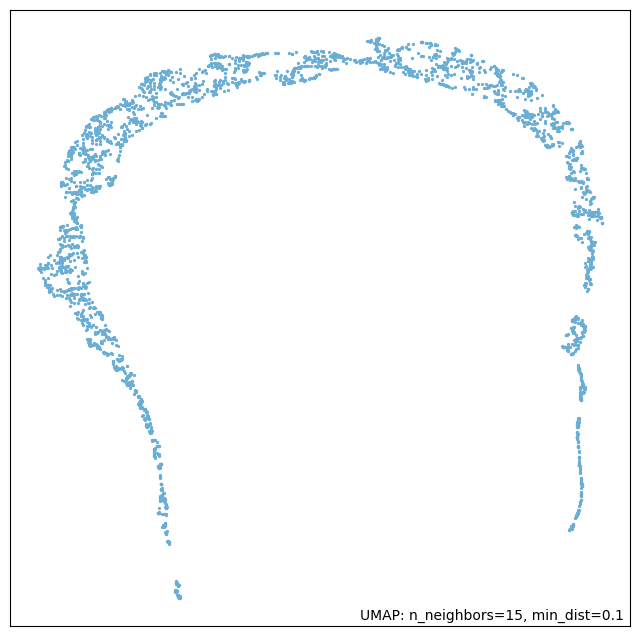

In [76]:
mapper = umap.UMAP().fit(mfcss_standardized_scaled[0])
umap.plot.points(mapper)

<Axes: >

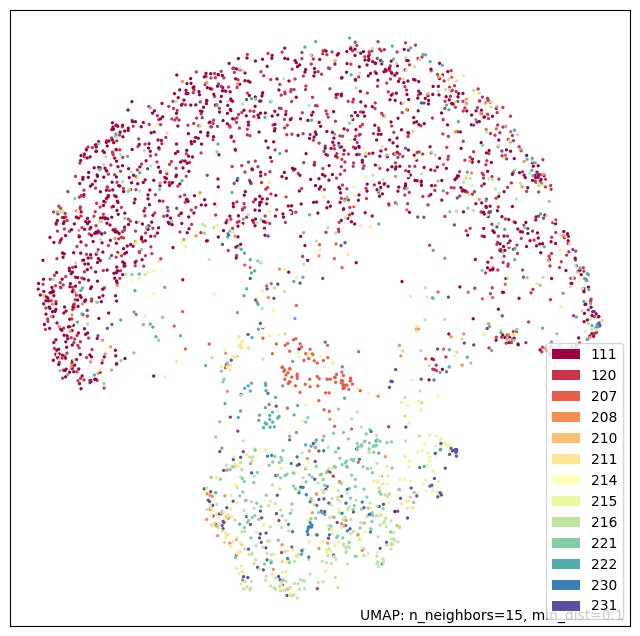

In [86]:
mapper = umap.UMAP().fit(mfccs_flat)

#labels = pup2mother_All['label_context']
#labels = pup2mother_All['label_addressee']
labels = pup2mother_All['emitter']

umap.plot.points(mapper, labels = labels)

<Axes: >

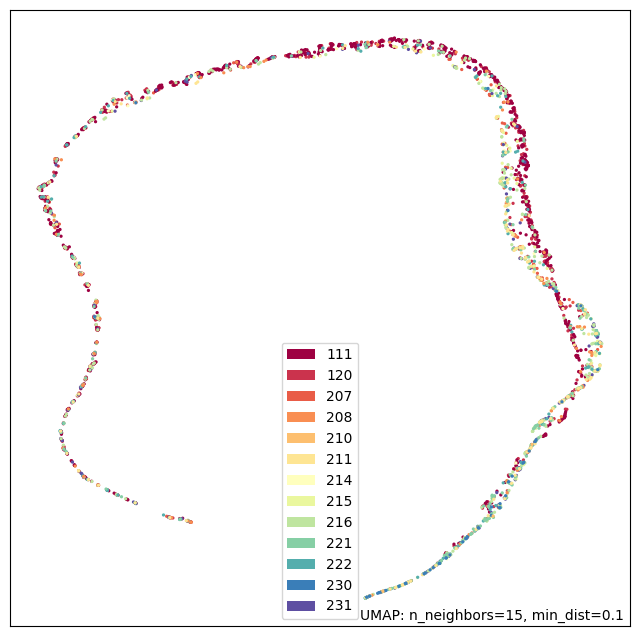

In [117]:
raw_data = np.array([ a.flatten() for a in pad_right(pup2mother_All['mfccs'])] )

mapper = umap.UMAP().fit(raw_data)

#labels = pup2mother_All['label_context']
#labels = pup2mother_All['label_addressee']
labels = pup2mother_All['emitter']

umap.plot.points(mapper, labels = labels)

In [9]:
mfccs = seq_mapped['mfccs']

# find the maximum time length of the mfccs
max_time = mfccs.apply(lambda x: x.shape[1]).max()

In [10]:
# pad the mfccs on the right along the time axis
mfccs_padded = mfccs.apply(lambda x: np.pad(x, ((0, 0), (0, max_time - x.shape[1])), mode='constant'))

# create a DataFrame from the padded mfccs
df = pd.DataFrame(mfccs_padded.apply(lambda x : x.flatten()).tolist())

# create a StandardScaler object
scaler = StandardScaler()

# standardize the values along the coefficient axis
df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# view the result
print(df_standardized)

         0         1         2         3         4         5         6      \
0     0.787718  0.667939  0.443500  0.342595  0.496626  0.543631  0.477775   
1    -1.095236 -0.966854 -0.730329 -0.287475 -0.038452  0.072946  0.144248   
2    -0.860428 -0.811964 -0.874581 -0.940415 -0.981407 -1.010454 -1.002841   
3     0.744094  0.623199  0.403512  0.231338  0.224200  0.242490  0.309244   
4     0.604963  0.472575  0.288780  0.177441  0.081522  0.059743  0.065591   
...        ...       ...       ...       ...       ...       ...       ...   
3530  0.433649  0.648787  0.656587  0.454677  0.327935  0.238721  0.115853   
3531 -0.147905 -0.198841 -0.381468 -0.556184 -0.648386 -0.677446 -0.723388   
3532  0.061752  0.014547 -0.140100 -0.332882 -0.465575 -0.555020 -0.620606   
3533  0.485795  0.482267  0.183038 -0.196136 -0.476764 -0.670954 -0.796631   
3534  0.427754  0.351713  0.149643 -0.060777 -0.186548 -0.311611 -0.406858   

         7         8         9      ...     10990     10991    

In [141]:
df_standardized.values.shape

(3129, 11000)

<Axes: >

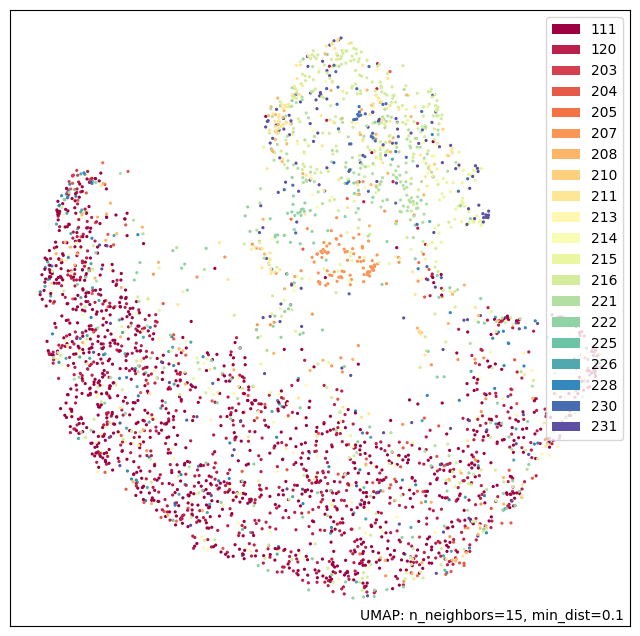

In [12]:
mapper = umap.UMAP().fit(df_standardized)

#labels = pup2mother_All['label_context']
#labels = pup2mother_All['label_addressee']
labels = seq_mapped['emitter']

umap.plot.points(mapper, labels = labels)

<Axes: >

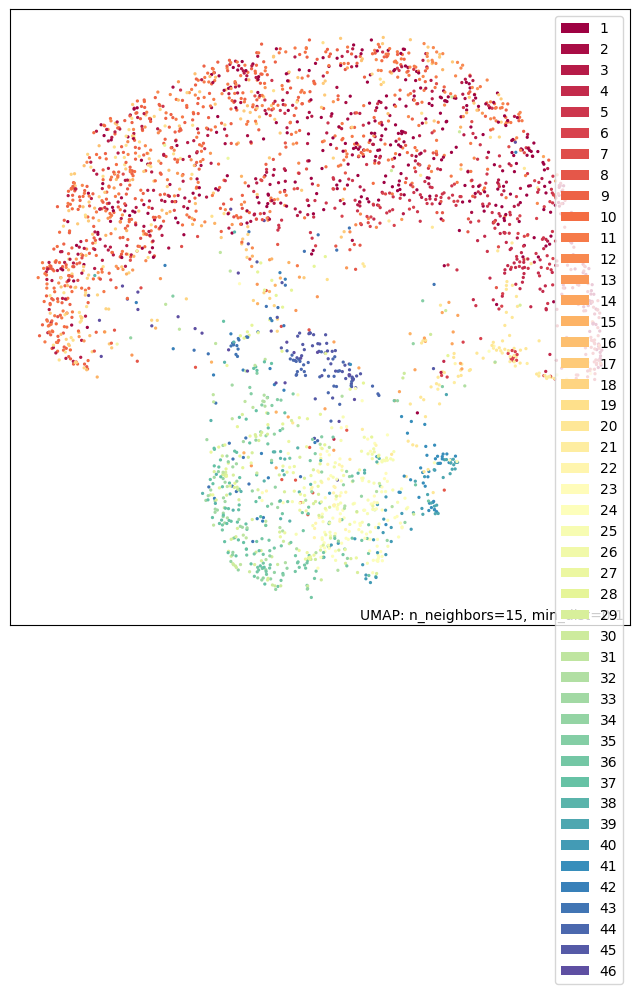

In [148]:
mapper = umap.UMAP().fit(df_standardized)

#labels = pup2mother_All['label_context']
#labels = pup2mother_All['label_addressee']
labels = pup2mother_All['emitter']

umap.plot.points(mapper, labels = pup2mother_All['syllableID'])

<Axes: >

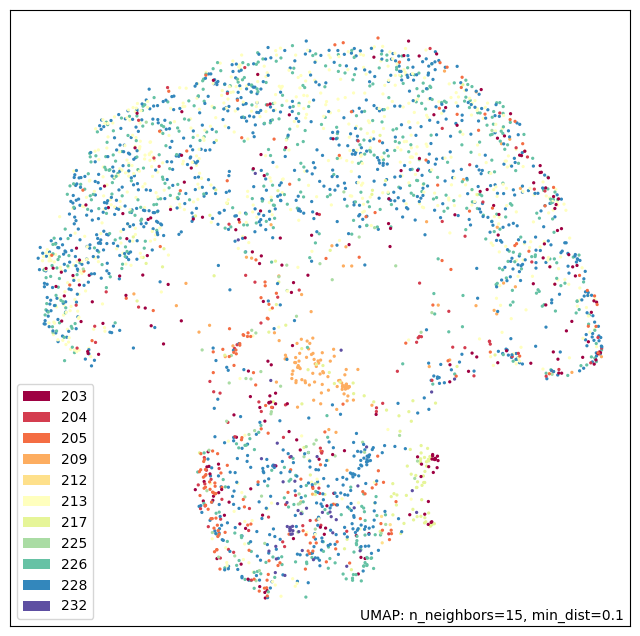

In [149]:
mapper = umap.UMAP().fit(df_standardized)

#labels = pup2mother_All['label_context']
labels = pup2mother_All['label_addressee']
#labels = pup2mother_All['emitter']

umap.plot.points(mapper, labels = labels)

<Axes: >

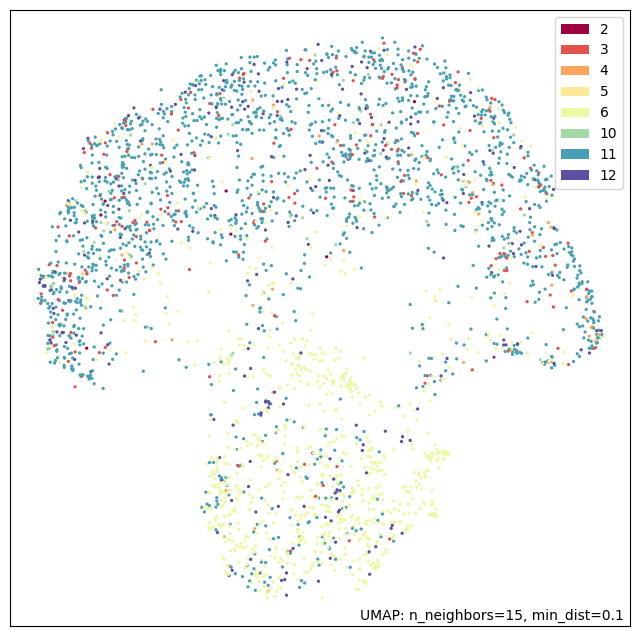

In [150]:
mapper = umap.UMAP().fit(df_standardized)

labels = pup2mother_All['label_context']
#labels = pup2mother_All['label_addressee']
#labels = pup2mother_All['emitter']

umap.plot.points(mapper, labels = labels)

In [19]:
# can I discriminate clusters of syllables in context 6 ?
test_df = pup2mother_All[pup2mother_All['label_context'] == 6]


<Axes: >

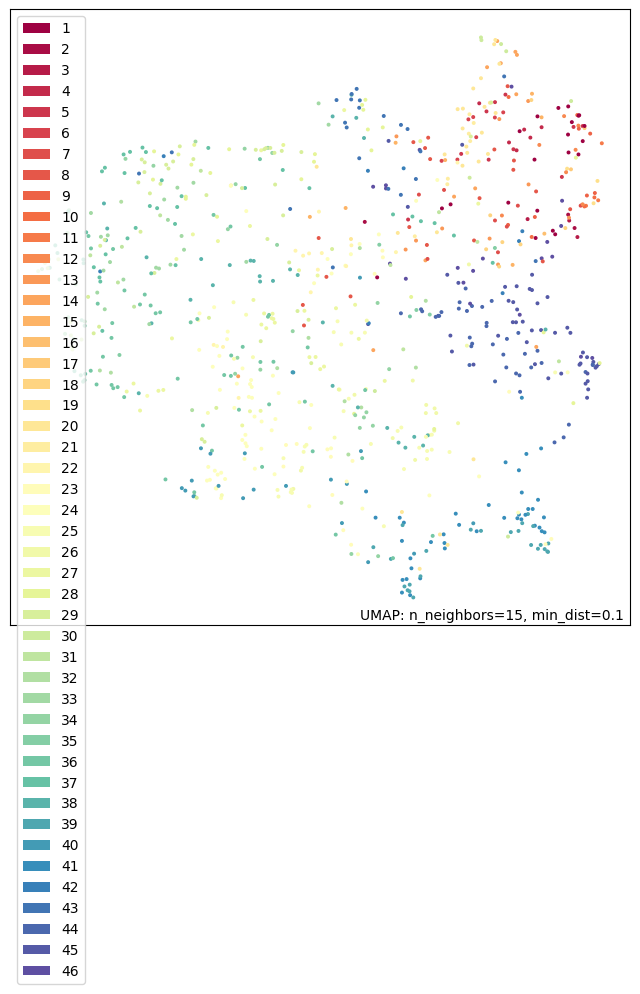

In [22]:
mapper = umap.UMAP().fit(df_standardized.loc[ test_df.index]  )

labels = test_df['syllableID']
#labels = pup2mother_All['label_addressee']
#labels = pup2mother_All['emitter']

umap.plot.points(mapper, labels = labels)

In [41]:
test_df = symbolic_sequences[['Seq_Syllables', 'Emitter']].copy()

In [44]:
test_df['Emitter'] = test_df['Emitter'].apply(lambda x: x[0])

In [86]:
y = test_df.query(f'Emitter not in {[111, 120]}').set_index('Emitter')['Seq_Syllables'].explode().index
x = test_df.query(f'Emitter not in {[111, 120]}').set_index('Emitter')['Seq_Syllables'].explode().values

In [81]:
from matplotlib import pyplot as plt

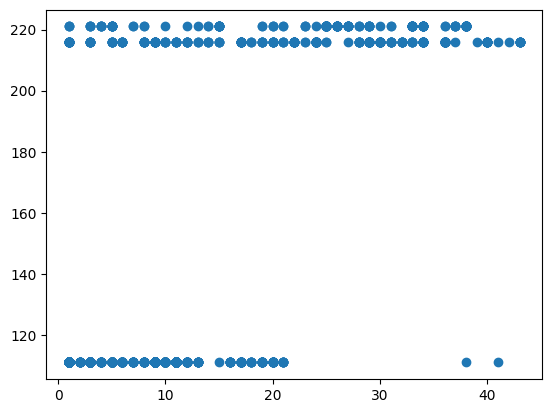

In [82]:
plt.scatter(x, y)

In [83]:
x

array([9, 9, 4, ..., 38, 38, 38], dtype=object)

In [57]:
y

Int64Index([207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
            ...
            230, 230, 230, 230, 230, 230, 230, 210, 210, 210],
           dtype='int64', name='Emitter', length=3129)

In [58]:
len(x)

3129

In [87]:
from scipy.stats import chi2_contingency

# create a contingency table of syllables by emitter
contingency_table = pd.crosstab(x, y)

# perform the chi-squared test

res = chi2_contingency(contingency_table)

# print the p-value
print("p-value:", res.pvalue)

p-value: 0.0


<Axes: >

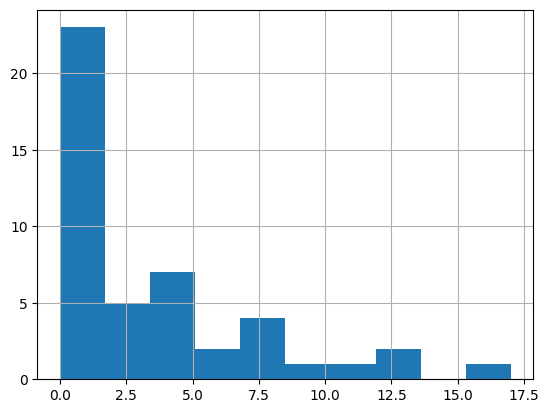

In [102]:
contingency_table.T.loc[222].hist()

In [105]:
freq = contingency_table.T.loc[222].values

In [113]:
# Rank the frequencies in descending order
rank = np.argsort(-freq)

# Compute the expected frequency for each rank using Zipf's law
N = len(freq)
K = freq[0] * rank[0]
exp_freq = K / np.arange(1, N+1)

# Compute the observed frequency for each rank
obs_freq = freq[rank]

# Compute the chi-squared statistic and p-value
chi2, p = chisquare(obs_freq, f_exp=exp_freq)

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.3018807263805271

In [107]:
from scipy.stats import chisquare

In [115]:
import scipy.stats as stats

def zipf_law_fisher_test(freqs):
    N = len(freqs)
    rank = list(range(1, N+1))
    H = sum(1/n for n in range(1, N+1))
    expected_freq = [N / (r * H) for r in rank]
    expected_high_rank = sum(expected_freq[:N//2])
    expected_low_rank = sum(expected_freq[N//2:])
    observed_freq = np.array(freqs) / sum(freqs)
    high_freq = sum(observed_freq[:N//2])
    low_freq = sum(observed_freq[N//2:])
    contingency_table = [[high_freq*N, low_freq*N], [expected_high_rank*N, expected_low_rank*N]]
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    return p_value

# Example usage
freqs = [100, 50, 33, 25, 20, 17, 14, 12, 11, 10]
p_value = zipf_law_fisher_test(freqs)
print("p-value:", p_value)

p-value: 1.0
